# Import lib

In [1]:
from utils import *

# Dataset

## Raw input

Raw data

In [3]:
# Load and preprocess
# Load
df = pd.read_csv(r'Dataset/dataset.csv')

# Preprocess
df = df[df['company'].isna()==False]
df.drop(columns = ['platform'], inplace=True)

    # for_own/gov_own -> dummy var (0 or null -> 0; else -> 1)
df[['for_own', 'gov_own']] = df[['for_own', 'gov_own']].fillna(0)
df['for_own'] = df['for_own'].apply(
    lambda x: 0 if x == 0  else 1)
df['gov_own'] = df['gov_own'].apply(
    lambda x: 0 if x == 0  else 1)

    ## ----- Data prescaled ------- ##
df_raw = df.copy()
df_raw.sort_values(by=['company', 'year'], ascending=True, inplace=True)

To better reflect the value of the data, I scaled all vars based on GDP deflator of year 2010 for all vars (except percentage based vars)

In [4]:
# Scaled data to GDP deflator 2010
df_raw_deflator = df_raw.copy()
df_raw_deflator['deflator_scaled'] = df_raw_deflator['year'].map(
    {2015: 0.71, 2016: 0.70, 2017: 0.67,2018: 0.65,2019: 0.63,2020: 0.62,2021: 0.60,2022: 0.58,2023: 0.57,2024: 0.54})

# Scaled
df_raw_deflator[['ebitda', 'revenue', 'cogs', 'sales_cost',
       'admin_cost', 'net_op_profit', 'short_receive', 'in_stock',
       'invest_nav', 'long_receive', 'long_liability', 'short_liability',
       'cash', 'fixed_asset', 'other_long_asset', 'cwip', 'other_short_asset',
       'long_invest', 'equity_fund', 'other_fund', 'market_cap', 'ev']] = \
df_raw_deflator[['ebitda', 'revenue', 'cogs', 'sales_cost',
       'admin_cost', 'net_op_profit', 'short_receive', 'in_stock',
       'invest_nav', 'long_receive', 'long_liability', 'short_liability',
       'cash', 'fixed_asset', 'other_long_asset', 'cwip', 'other_short_asset',
       'long_invest', 'equity_fund', 'other_fund', 'market_cap', 'ev']].apply(lambda x:
                                                                        x*df_raw_deflator['deflator_scaled'])

# drop the scaler
df_raw_deflator.drop(columns='deflator_scaled', inplace=True)

Comment:
- Target variable (outcome): ebitda dummy, revenue, roa, roe, roic, roce, value_added (see vars_used.txt file for details)
- As raw input, all the rest vars are used as features

## Target feature EDA

REVENUE:
+ After applying log, skew and kurtosis of revenue decreases -> good
+ The distribution of revenue turns into normal dist

-------- Original -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
revenue,18761.0,1.960506e+12,1.098396e+13,726643.1,7.247256e+10,2.417693e+11,9.353446e+11,3.810080e+14,18.2543,423.6201


------- Log scaled ------------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
revenue,18761.0,26.2645,2.0033,13.4962,25.0065,26.2112,27.5642,33.5738,-0.1356,0.8246


<Axes: title={'center': 'Revenue Log'}, xlabel='revenue', ylabel='Count'>

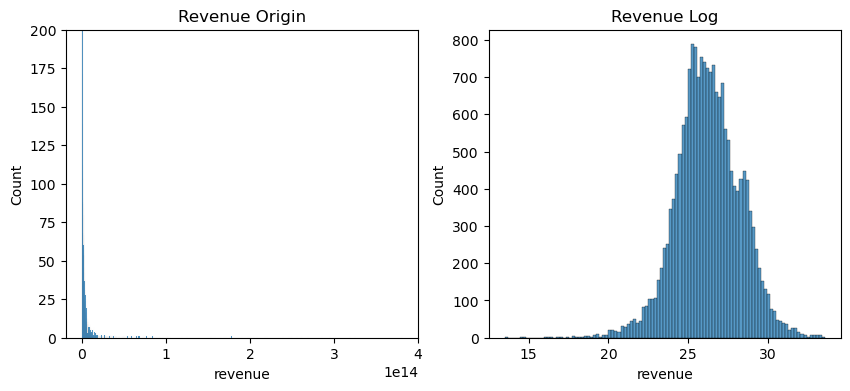

In [18]:
# Revenue
df_rev = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit', 'roa','roe', 'roic', 'roce'])
  # Filter for rev > 0
df_rev = df_rev[df_rev['revenue']>0]
print('-------- Original -----------')
display(eda_describe(df_rev.drop(columns='year'))[:1])
print('------- Log scaled ------------')
df_rev_log = df_rev.copy()
df_rev_log['revenue'] = df_rev_log['revenue'].apply(lambda x: np.log(x))
display(eda_describe(df_rev_log.drop(columns='year'))[:1])
    # Chart
f, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].set_title('Revenue Origin')
ax[0].set_ylim(top=200)
sns.histplot(x=df_rev['revenue'], ax=ax[0])
ax[1].set_title('Revenue Log')
sns.histplot(x=df_rev_log['revenue'], ax=ax[1])

VALUE ADD:
+ 43 companies have no value_added, contributing mostly to the skewness of 3 of the transformed data
+ However, the main part is still normal dist

-------- Original -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
value_add,18757.0,3.421037e+12,1.917077e+13,-1.911144e+11,1.360287e+11,4.546012e+11,1.744975e+12,6.069065e+14,17.8876,411.2018


------- Log scaled ------------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
value_add,18761.0,26.8103,2.3686,0.0,25.6351,26.8424,28.1874,34.0394,-3.6224,39.7531


<Axes: title={'center': 'Value Add Log'}, xlabel='value_add', ylabel='Count'>

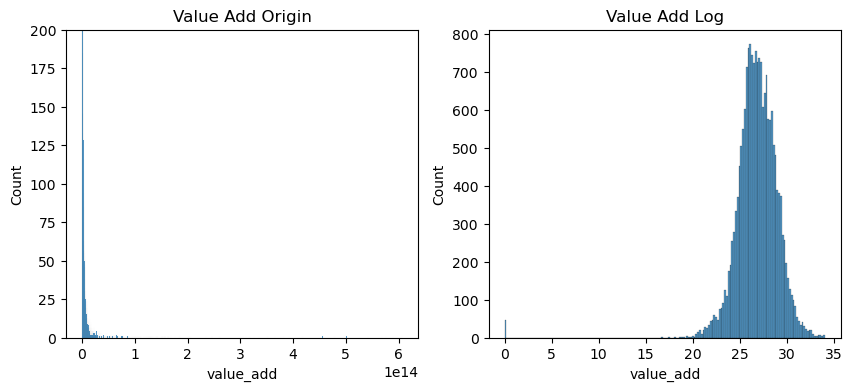

In [21]:
# Value added
df_valad = df_rev.copy()
df_valad['value_add'] = df_valad['revenue'] -df_valad['cogs'] -df_valad['sales_cost'] -df_valad['admin_cost']
df_valad.drop(columns = ['revenue', 'cogs', 'sales_cost', 'admin_cost'], inplace=True)

print('-------- Original -----------')
display(eda_describe(df_valad.drop(columns='year'))[-1:])
print('------- Log scaled ------------')
df_valad_log = df_valad.copy()
df_valad_log['value_add'] = df_valad_log['value_add'].apply(
    lambda x: np.log(x+1) if x > 0 else np.log(1)
)
display(eda_describe(df_valad_log.drop(columns='year'))[-1:])
    # Chart
f, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].set_title('Value Add Origin')
ax[0].set_ylim(top=200)
sns.histplot(x=df_valad['value_add'], ax=ax[0])
ax[1].set_title('Value Add Log')
sns.histplot(x=df_valad_log['value_add'], ax=ax[1])

ROA, ROE, ROIC, ROCE:
+ Since mean and median of these metric are close, the data is likely symetric (though skew might be high)
+ SO no transformation needed

In [23]:
# roa roe roic roce
df_roa = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roe', 'roic', 'roce', 'revenue'])
df_roe = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roa', 'roic', 'roce', 'revenue'])
df_roic = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roe', 'roa', 'roce', 'revenue'])
df_roce = df_raw_deflator.drop(columns=['ebitda', 'net_op_profit','roe', 'roa', 'roic', 'revenue'])

# Describe
print('-------- ROA -----------')
display(eda_describe(df_roa[['roa']]))
print('-------- ROE -----------')
display(eda_describe(df_roe[['roe']]))
print('-------- ROIC -----------')
display(eda_describe(df_roic[['roic']]))
print('-------- ROCE -----------')
display(eda_describe(df_roce[['roce']]))

-------- ROA -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
roa,19080.0,0.0343,0.1528,-9.5844,0.0019,0.0264,0.0695,4.5785,-20.6086,1172.7049


-------- ROE -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
roe,19080.0,0.0973,1.6631,-60.7224,0.0087,0.0716,0.155,111.7216,20.7107,1877.2417


-------- ROIC -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
roic,19080.0,0.0472,4.7567,-552.8697,0.0,0.0479,0.1161,262.7942,-73.5527,10088.101


-------- ROCE -----------


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
roce,19080.0,0.0959,1.3622,-59.4495,0.0029,0.0712,0.1606,160.676,81.4723,10338.7582
